# NLP
# Lab 6 - Wordnet

In [1]:
import requests
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
base_url = 'http://api.slowosiec.clarin-pl.eu/plwordnet-api/'

def get_senses_by_lemma(lemma, part_of_speech=None):
    url = base_url + 'senses/search?lemma={}'.format(lemma)
    if part_of_speech:
        url += '&partOfSpeech={}'.format(part_of_speech)
    return requests.get(url).json()

def get_synset_by_sense_id(sense_id):
    url = base_url + 'senses/{}/synset'.format(sense_id)
    return requests.get(url).json()

def get_senses_by_synset_id(synset_id):
    url = base_url + 'synsets/{}/senses'.format(synset_id)
    return requests.get(url).json()

def get_relations_from_synset(synset_id):
    url = base_url + 'synsets/{}/relations/from'.format(synset_id)
    return requests.get(url).json()

In [3]:
def draw_graph(graph, pos):
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True)
    plt.axis('off')
    plt.show()

#### Zadanie 3.

In [4]:
senses = get_senses_by_lemma('szkoda', 'noun')['content']
for sense in senses:
    print('\nSENSE: ' + sense['domain']['description'])
    synset = get_synset_by_sense_id(sense['id'])
    senses_in_synset = get_senses_by_synset_id(synset['id'])
    for sense_in_synset in senses_in_synset:
        print('\tSYNONYM: ' + sense_in_synset['lemma']['word'])


SENSE: plWN miejsca i umiejscowienie
	SYNONYM: szkoda

SENSE: plWN posiadanie i jego zmiana
	SYNONYM: strata
	SYNONYM: utrata
	SYNONYM: szkoda
	SYNONYM: uszczerbek


#### Zadanie 4.

In [5]:
def get_relation_closure(synset_id, relation_name):
    relations_from = get_relations_from_synset(synset_id)
    synset_to_ids = [relation['synsetTo']['id'] for relation in relations_from if relation['relation']['name']==relation_name]
    result = []
    for synset_to_id in synset_to_ids:
        result.append('{} -> {}'.format(synset_id, synset_to_id))
        for next_synset_to_id in get_relation_closure(synset_to_id, relation_name):
            result.append(next_synset_to_id)
    return result

In [6]:
sense_id = get_senses_by_lemma('wypadek drogowy')['content'][0]['id']

In [7]:
synset_id = get_synset_by_sense_id(sense_id)['id']

In [8]:
relations_from = get_relations_from_synset(synset_id)

In [9]:
closure = get_relation_closure(relations_from[0]['synsetFrom']['id'], 'hiponimia')
closure

['410902 -> 410901', '410901 -> 3982', '3982 -> 27419', '27419 -> 6526']

In [10]:
def convert_synsets_to_senses_relations_graph(synset_relations):
    graph = nx.DiGraph()
    for ind, relation in enumerate(synset_relations):
        synset_from, synset_to = relation.split(' -> ')
        senses_from = get_senses_by_synset_id(synset_from)
        senses_to = get_senses_by_synset_id(synset_to)
        lemmas_from = [sense['lemma']['word'] for sense in senses_from]
        lemmas_to = [sense['lemma']['word'] for sense in senses_to]
        for lemma_from in lemmas_from:
            if ind == 0:
                graph.add_node(lemma_from)
            for lemma_to in lemmas_to:
                graph.add_node(lemma_to)
                graph.add_edge(lemma_from, lemma_to)
    return graph

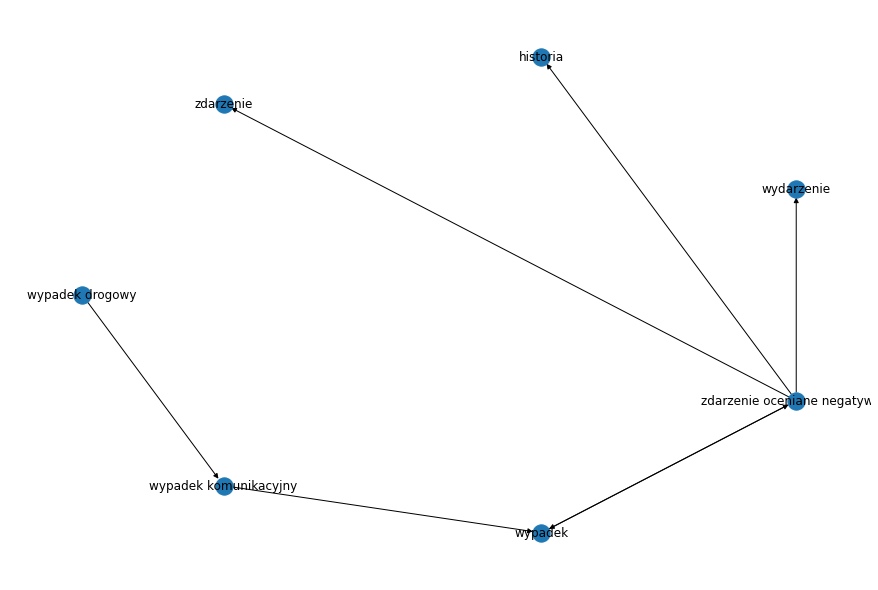

In [11]:
graph = convert_synsets_to_senses_relations_graph(closure)
draw_graph(graph, nx.shell_layout(graph))

#### Zadanie 5.

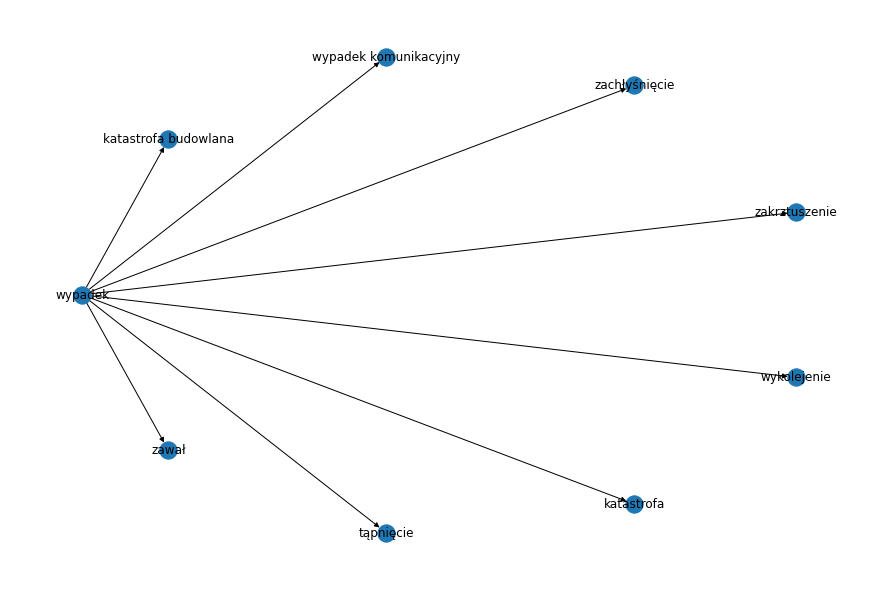

In [12]:
senses = get_senses_by_lemma('wypadek')['content']
sense = [sense for sense in senses if sense['lemma']['word'] == 'wypadek'][0]
synset_id = get_synset_by_sense_id(sense['id'])['id']
relations_from = get_relations_from_synset(synset_id)
hyponymy_relations = [relation for relation in relations_from if relation['relation']['name'] == 'hiperonimia']
graph = nx.DiGraph()
for relation in hyponymy_relations:
    synset_to_id = relation['synsetTo']['id']
    hyponyms = get_senses_by_synset_id(synset_to_id)
    words = [hyponym['lemma']['word'] for hyponym in hyponyms]
    word_from = sense['lemma']['word']
    graph.add_node(word_from)
    for word in words:
        graph.add_node(word)
        graph.add_edge(word_from, word)
draw_graph(graph, nx.shell_layout(graph))

#### Zadanie 6.

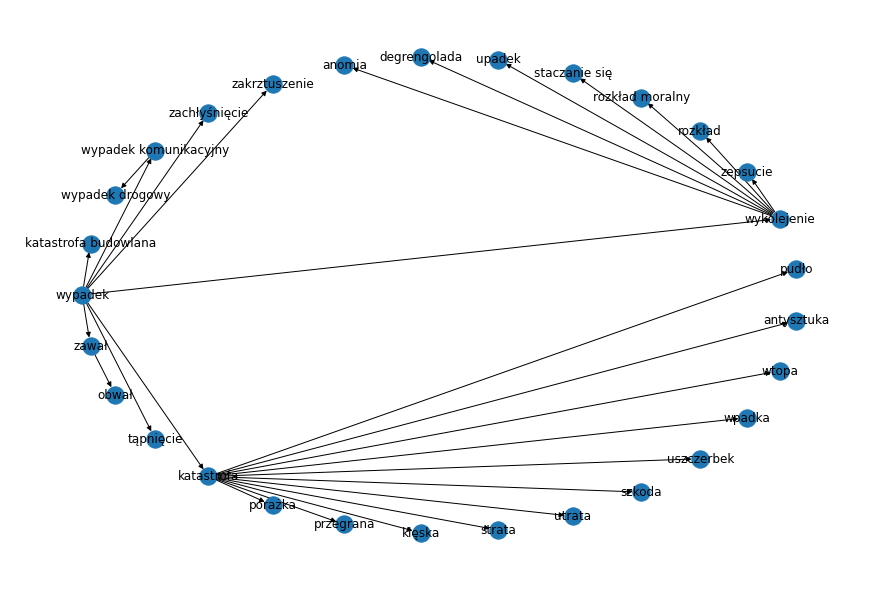

In [13]:
senses = get_senses_by_lemma('wypadek')['content']
sense = [sense for sense in senses if sense['lemma']['word'] == 'wypadek'][0]
synset_id = get_synset_by_sense_id(sense['id'])['id']
relations_from = get_relations_from_synset(synset_id)
hyponymy_relations = [relation for relation in relations_from if relation['relation']['name'] == 'hiperonimia']
graph = nx.DiGraph()
for relation in hyponymy_relations:
    synset_to_id = relation['synsetTo']['id']
    hyponyms = get_senses_by_synset_id(synset_to_id)
    words = [hyponym['lemma']['word'] for hyponym in hyponyms]
    word_from = sense['lemma']['word']
    graph.add_node(word_from)
    for word in words:
        graph.add_node(word)
        graph.add_edge(word_from, word)
        senses_second_order = get_senses_by_lemma(word)['content']
        senses_second_order = [sense_second for sense_second in senses_second_order if sense_second['lemma']['word'] == word]
        for sense_second in senses_second_order:            
            synset_id_second = get_synset_by_sense_id(sense_second['id'])['id']
            relations_from_second = get_relations_from_synset(synset_id_second)
            hyponymy_relations_second = [relation_second for relation_second in relations_from_second if relation_second['relation']['name'] == 'hiperonimia']
            for relation_second in hyponymy_relations_second:
                synset_to_id_second = relation_second['synsetTo']['id']
                hyponyms_second = get_senses_by_synset_id(synset_to_id_second)
                words_second = [hyponym_second['lemma']['word'] for hyponym_second in hyponyms_second]
                for word_second in words_second:
                    graph.add_node(word_second)
                    graph.add_edge(word, word_second)
draw_graph(graph, nx.shell_layout(graph))

#### Zadanie 7.

In [14]:
def get_relations_graph_for_lexemes(lexemes):
    senses = [sense for lexeme in lexemes for sense in get_senses_by_lemma(lexeme[0])['content'] if sense['senseNumber']==lexeme[1] and sense['lemma']['word']==lexeme[0]]
    lemmas_by_synset_id = {}
    for sense in senses:
        synset_id = get_synset_by_sense_id(sense['id'])['id']
        if synset_id in lemmas_by_synset_id:
            lemmas_by_synset_id[synset_id].append(sense['lemma']['word'])
        else:
            lemmas_by_synset_id[synset_id] = [sense['lemma']['word']]
    graph = nx.MultiDiGraph()
    edge_labels = {}
    for synset_id, lemmas in lemmas_by_synset_id.items():
        for lemma in lemmas:
            graph.add_node(lemma)
        relations = [relation for relation in get_relations_from_synset(synset_id) if relation['relation']['name']=='hiponimia']
        for relation in relations:
            synset_to_id = relation['synsetTo']['id']
            if synset_to_id in lemmas_by_synset_id:
                lemmas_to = lemmas_by_synset_id[synset_to_id]
                for lemma_to in lemmas_to:
                    if lemma_to not in graph:
                        graph.add_node(lemma_to)
                    for lemma in lemmas:
                        graph.add_edge(lemma, lemma_to)
                        edge_labels [(lemma, lemma_to)] = relation['relation']['name']
    plt.figure(figsize=(12, 8))
    nx.draw(graph, nx.circular_layout(graph), with_labels=True)
    nx.draw_networkx_edge_labels(graph, nx.circular_layout(graph), edge_labels)
    plt.axis('off')
    plt.show()

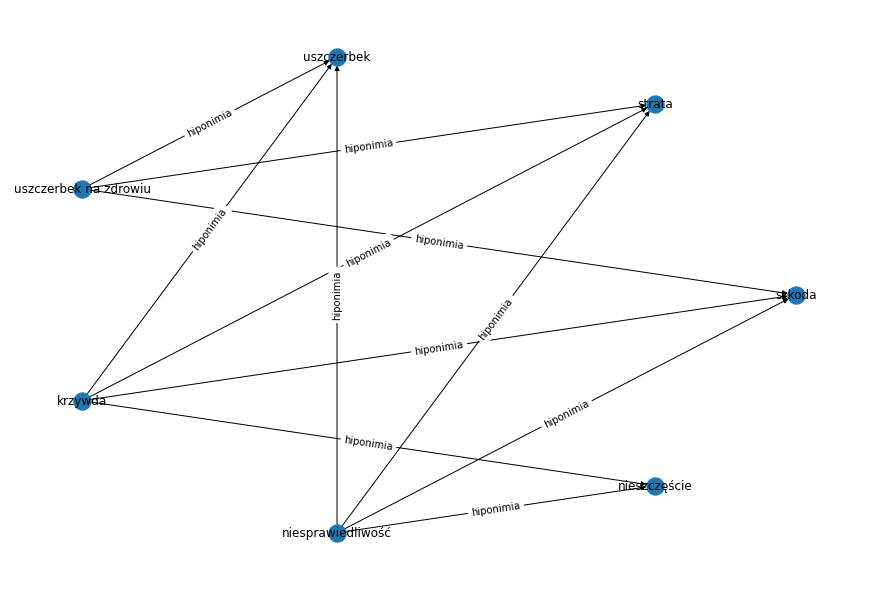

In [16]:
get_relations_graph_for_lexemes([('szkoda', 2), ('strata', 1), ('uszczerbek', 1), ('szkoda majątkowa', 1), ('uszczerbek na zdrowiu', 1), ('krzywda', 1), ('niesprawiedliwość', 1), ('nieszczęście', 2)])

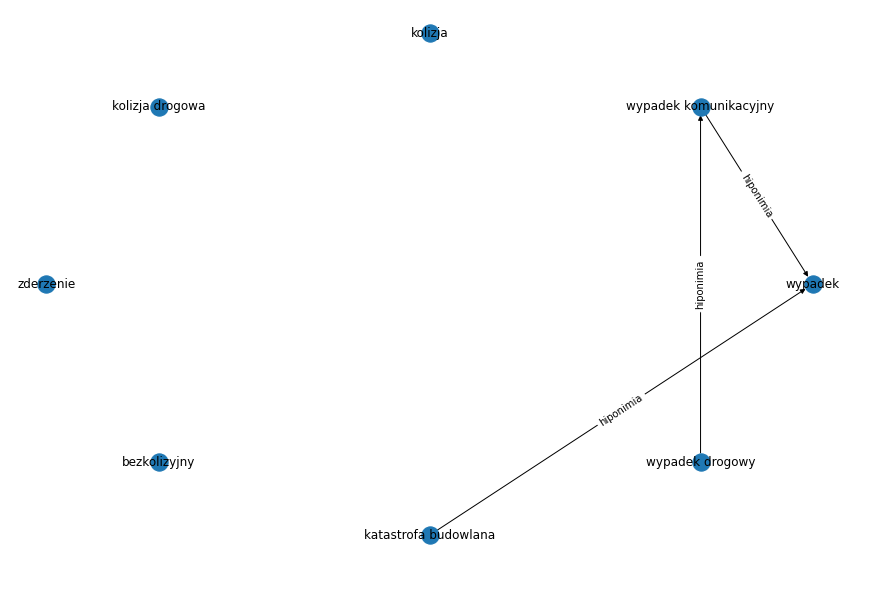

In [17]:
get_relations_graph_for_lexemes([('wypadek', 1), ('wypadek komunikacyjny', 1), ('kolizja', 2), ('zderzenie', 2), ('kolizja drogowa', 1), ('bezkolizyjny', 2), ('katastrofa budowlana', 1), ('wypadek drogowy', 1)])

#### Zadanie 9.

Krokiem koniecznym do korzystania ze zbiorów takich jak Wordnet jest lematyzacja słów przed przystąpieniem do dalszego przetwarzania, gdyż sieć opiera się na zlematyzowanych wyrazach.  
Jeśli chodzi o rozpoznawanie sensu zdań z użyciem słowosieci to może być ono dość trudne i nieefektywne, gdyż słowa często mogą występować w różnych znaczeniach i rolach w zdaniu, a słowosieć bez podania dodatkowych informacji nie będzie w stanie wyłapać takich cech.  
Problemem dla ustrukturyzowanych źródeł takich jak słowosieć jest koniecznosć ręcznego wprowadzania wszystkich danych oraz ewolucja języka.